In [9]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

from tensorflow.keras.callbacks import Callback

#!pip install -U efficientnet
from keras import layers
import efficientnet.keras as efn
from keras import regularizers 

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import Xception


import seaborn as sn
import matplotlib.pyplot as plt

In [38]:
# Some constant
BATCH_SIZE = 32
IMG_SIZE = 224
LABEL_MODE = "categorical"
MODEL_NAME = "efficientnet_b0_v1"

In [4]:
def process_normalize(image, label):
    #print("call process_normalize")
    image = tf.cast(image/255., tf.float32)
    # Transformation needed here
    return image, label

In [5]:
def load_image_dataset_from_directory(directory):
    ds = image_dataset_from_directory(directory,
                                      batch_size=BATCH_SIZE,
                                      image_size=(IMG_SIZE, IMG_SIZE),
                                      label_mode=LABEL_MODE)
    #print(ds.class_names)
    return ds.prefetch(int(BATCH_SIZE/2)).map(process_normalize), ds.class_names

In [7]:
train_ds, labels = load_image_dataset_from_directory("../data/preprocessed/img/Train/")
test_ds, _ = load_image_dataset_from_directory("../data/preprocessed/img/Test/")
val_ds, _ = load_image_dataset_from_directory("../data/preprocessed/img/Validation/")

NB_CLASS = len(labels)
labels

Found 2873 files belonging to 2 classes.
Found 957 files belonging to 2 classes.
Found 957 files belonging to 2 classes.


['Begnin', 'Maligne']

In [12]:
eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model=Sequential()
model.add(eff_net)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(NB_CLASS, activation='softmax'))

alpha = 1e-3  # weight decay coefficient
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 4,214,302
Trainable params: 4,172,030
Non-trainable params: 42,272
_______________________________________

In [13]:
# callback - if accuracy doesn't improve after 3 epoch then reduce lr by factor 0.5 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=3, min_lr=0.000005)

In [21]:

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        loss, acc = self.model.evaluate(self.test_data, verbose=1)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [14]:
# compile the model 
optimizer=optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss="categorical_crossentropy", metrics=['accuracy'])


In [22]:
# train the model
history = model.fit(train_ds, epochs=1, validation_data=val_ds, callbacks=[reduce_lr, TestCallback(test_ds)])

30/30 [==============================] - 58s 2s/step - loss: 0.5890 - accuracy: 0.8830

Testing loss: 0.5890159010887146, acc: 0.8829675912857056



In [17]:
# integrated as CallBack in the fit
# model.evaluate(test_ds)

30/30 [==============================] - 123s 4s/step - loss: 0.5541 - accuracy: 0.8777


[0.5540841221809387, 0.8777429461479187]

In [25]:
y_pred = model.predict(test_ds)

y_true =  np.array([])
for _, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])


NameError: name 'confusion_matrix' is not defined

In [35]:
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=-1))
cm

array([[245, 209],
       [257, 246]])

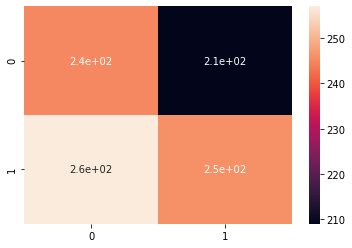

In [36]:
sn.heatmap(cm, annot=True)
plt.show()

In [31]:
print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=["Begnin", "Malignant"]))

              precision    recall  f1-score   support

      Begnin       0.49      0.54      0.51       454
   Malignant       0.54      0.49      0.51       503

    accuracy                           0.51       957
   macro avg       0.51      0.51      0.51       957
weighted avg       0.52      0.51      0.51       957



In [ ]:
model.save(MODEL_NAME)
